In [26]:
import astropy.io.fits as fits
import astropy.wcs as wcs
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import match_coordinates_sky
from astropy import constants as const
from astropy import cosmology
cosmo = cosmology.Planck15

In [2]:
datadir='../../doc/20170617_Stacking/maps/clustercats/'

In [119]:
def df_add_xy(field, df):
    order = [c for c in df.columns]
    # find the x, y solution with all quad
    for inst in [1,2]:
        hdrdir = '/Users/ytcheng/ciber/doc/20170617_Stacking/maps/astroutputs/inst' + str(inst) + '/'
        xoff = [0,0,512,512]
        yoff = [0,512,0,512]
        for iquad,quad in enumerate(['A','B','C','D']):
            hdulist = fits.open(hdrdir + field + '_' + quad + '_astr.fits')
            wcs_hdr=wcs.WCS(hdulist[('primary',1)].header, hdulist)
            hdulist.close()
            src_coord = SkyCoord(ra=df['ra']*u.degree, dec=df['dec']*u.degree, frame='icrs')

            x_arr, y_arr = wcs_hdr.all_world2pix(df['ra'],df['dec'],0)
            df['x' + quad] = x_arr + xoff[iquad]
            df['y' + quad] = y_arr + yoff[iquad]

        df['meanx'] = (df['xA'] + df['xB'] + df['xC'] + df['xD']) / 4
        df['meany'] = (df['yA'] + df['yB'] + df['yC'] + df['yD']) / 4

        # assign the x, y with the nearest quad solution
        df['x'+str(inst)] = df['xA'].copy()
        df['y'+str(inst)] = df['yA'].copy()
        for i in range(len(df)):
            if df['meanx'].iloc[i]<511.5 and df['meany'].iloc[i]<511.5:
                df['x'+str(inst)].iloc[i] = df['xA'].iloc[i]
                df['y'+str(inst)].iloc[i] = df['yA'].iloc[i]
            elif df['meanx'].iloc[i]<511.5 and df['meany'].iloc[i]>511.5:
                df['x'+str(inst)].iloc[i] = df['xB'].iloc[i]
                df['y'+str(inst)].iloc[i] = df['yB'].iloc[i]
            elif df['meanx'].iloc[i]>511.5 and df['meany'].iloc[i]<511.5:
                df['x'+str(inst)].iloc[i] = df['xC'].iloc[i]
                df['y'+str(inst)].iloc[i] = df['yC'].iloc[i]
            elif df['meanx'].iloc[i]>511.5 and df['meany'].iloc[i]>511.5:
                df['x'+str(inst)].iloc[i] = df['xD'].iloc[i]
                df['y'+str(inst)].iloc[i] = df['yD'].iloc[i]

    # write x, y to df
    order = order[:2] + ['x1','y1','x2','y2'] + order[2:]
    dfout = df[order].copy()
    
    return dfout

/Users/ytcheng/anaconda3/lib/python3.5/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


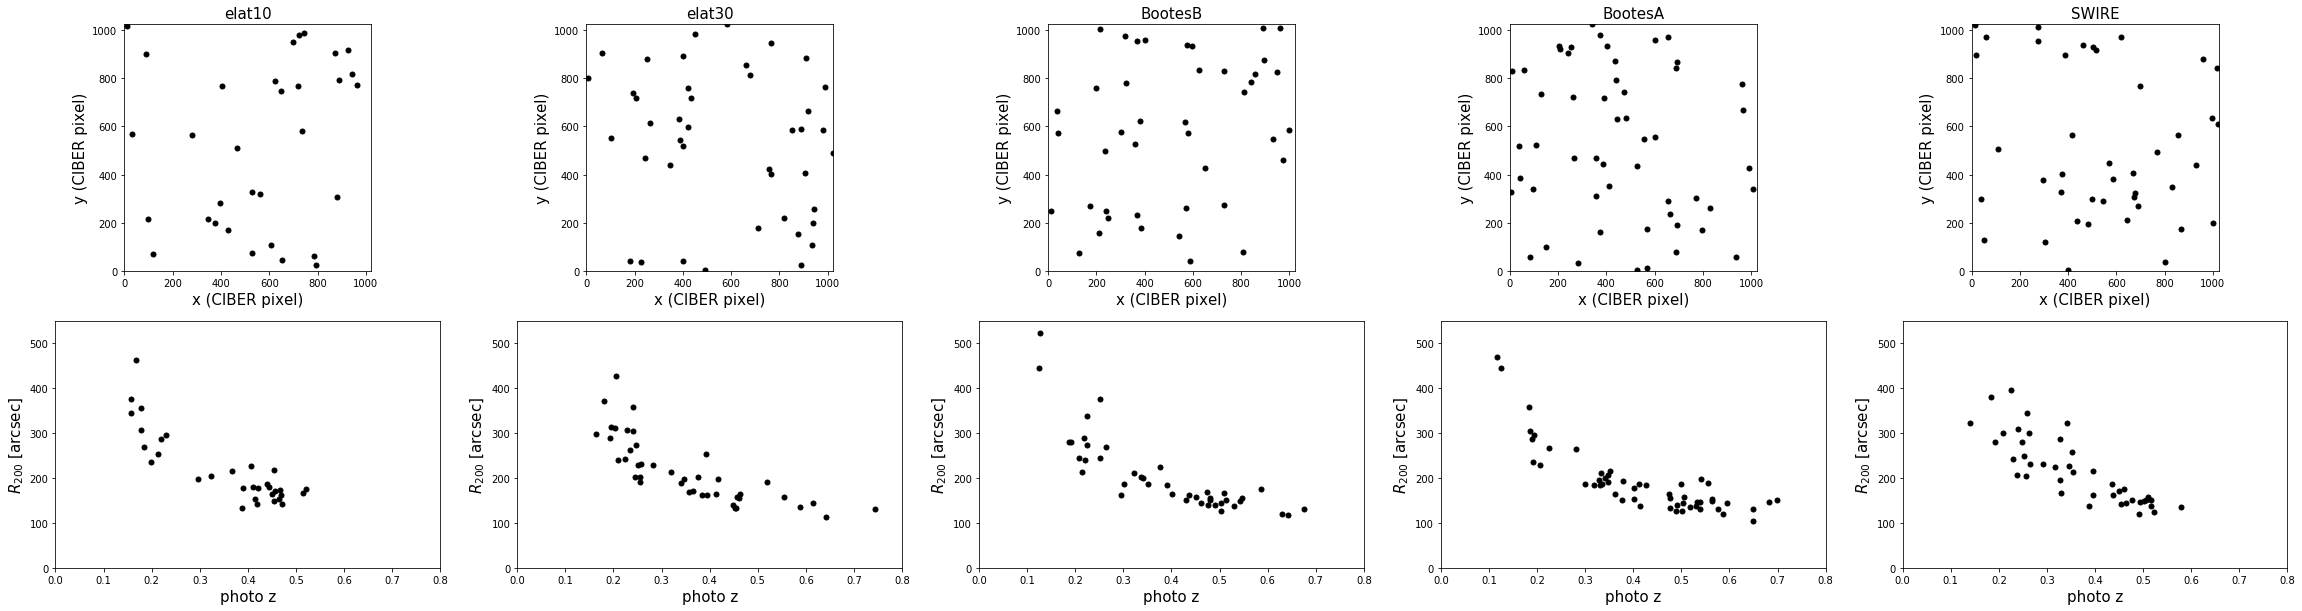

In [41]:
fig, ax = plt.subplots(2,5,figsize=(40,10))
m_bins = np.arange(16,20)
for i,field in enumerate(['elat10','elat30','BootesB','BootesA','SWIRE']): 
    df = pd.read_csv(datadir + field + '.csv')
    df = df_add_xy(field, df)
    df = df[(df['x1']>-0.5) & (df['x1']<1023.5) & (df['y1']>-0.5) & (df['y1']<1023.5)]
    df['r200_arcsec'] = (cosmo.arcsec_per_kpc_proper(df['zph']) * df['r200'] * 1e3).value
    
    ax[0][i].plot(df['x1'],df['y1'], 'k.', markersize = 10)
    ax[0][i].set_title(field, fontsize = 15)
    ax[0][i].set_xlabel('x (CIBER pixel)', fontsize = 15)
    ax[0][i].set_ylabel('y (CIBER pixel)', fontsize = 15)
    ax[0][i].set_xlim([-0.5, 1023.5])
    ax[0][i].set_ylim([-0.5, 1023.5])
    ax[0][i].set_aspect('equal')

    ax[1][i].plot(df['zph'],df['r200_arcsec'], 'k.', markersize = 10)
    ax[1][i].set_ylabel('y (CIBER pixel)', fontsize = 15)
    ax[1][i].set_xlabel('photo z', fontsize = 15)
    ax[1][i].set_ylabel('$R_{200}$ [arcsec]', fontsize = 15)
    ax[1][i].set_xlim([0,0.8])
    ax[1][i].set_ylim([0,550])
plt.savefig('clusters.png')

# Check if there is super low z galaxy

First try using the SDSS catalog. However, the very bright source,e.g. the brightest one in BootesB is indeed a star when I search for the coordinate in SIMBAD. So, don't use this data set to search for bright low-z extended galaxies.

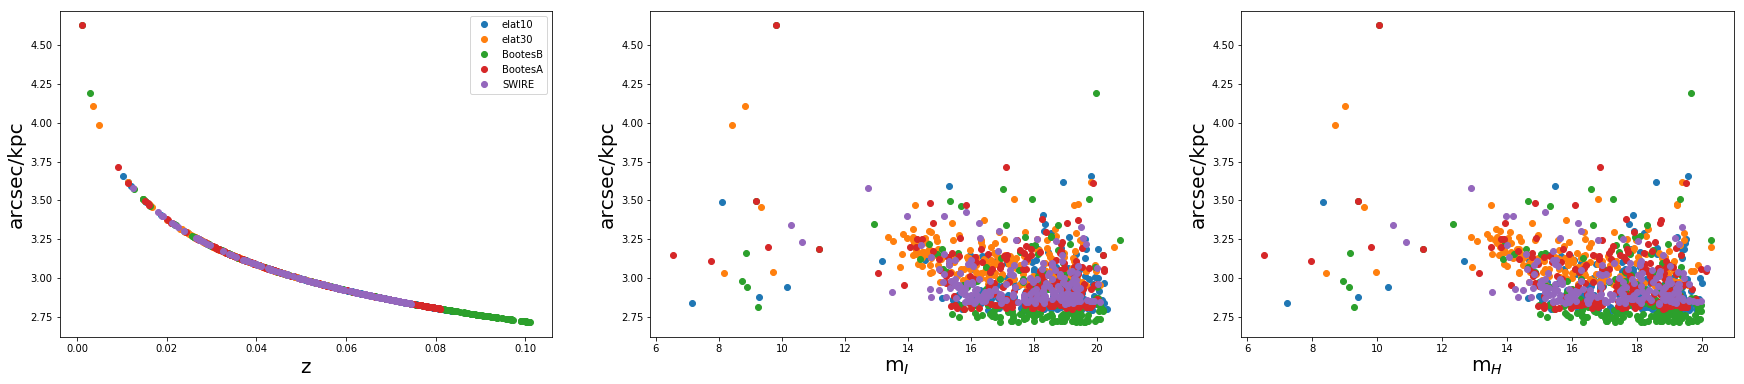

In [75]:
#
flight = 40030
inst = 1
catcoorddir='../../doc/20170617_Stacking/maps/catcoord/TM'+str(inst)+'/'

fig, ax = plt.subplots(1,3,figsize=(30,6))
for i,field in enumerate(['elat10','elat30','BootesB','BootesA','SWIRE']): 
    fname = catcoorddir+'PanSTARRS/'+ field + '.txt'
    df = pd.read_csv(fname)
    df = df[(df['x']>-0.5) & (df['x']<1023.5) & (df['y']>-0.5) & (df['y']<1023.5)]
    z_arr = np.array(df['Photz'])
    I_arr = np.array(df['I_corr'])
    H_arr = np.array(df['H_corr'])
    sp = np.where(z_arr >= 0)[0]
    z_arr = z_arr[sp]
    I_arr = I_arr[sp]
    H_arr = H_arr[sp]
    s_arr = np.array(cosmo.arcsec_per_kpc_proper(z_arr).to(u.arcsec/u.Mpc))
    
    sortidx = np.argsort(s_arr)[::-1]
    z_arr = z_arr[sortidx]
    I_arr = I_arr[sortidx]
    H_arr = H_arr[sortidx]
    s_arr = s_arr[sortidx]
    ax[0].plot(z_arr[:200],np.log10(s_arr[:200]),'o', label = field)
    ax[1].plot(I_arr[:200],np.log10(s_arr[:200]),'o', label = field)
    ax[2].plot(H_arr[:200],np.log10(s_arr[:200]),'o', label = field)
ax[0].set_xlabel('z', fontsize = 20)
ax[0].set_ylabel('arcsec/kpc', fontsize = 20)
ax[1].set_ylabel('arcsec/kpc', fontsize = 20)
ax[1].set_xlabel(r'm$_I$', fontsize = 20)
ax[2].set_ylabel('arcsec/kpc', fontsize = 20)
ax[2].set_xlabel(r'm$_H$', fontsize = 20)

ax[0].legend()

## Use 2MASS extended catalog

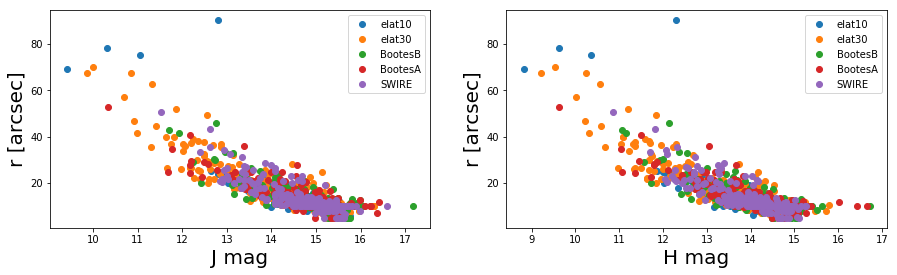

In [126]:
flight = 40030
inst = 1
catcoorddir='../../doc/20170617_Stacking/maps/2masscats/XSC/'

fig, ax = plt.subplots(1,2,figsize=(15,4))
for i,field in enumerate(['elat10','elat30','BootesB','BootesA','SWIRE']): 
    fname = catcoorddir+ field + '.tbl'
    data = np.loadtxt(fname, skiprows=38, usecols=(0,1,2,3,5,7))
    df = pd.DataFrame(data, columns=['ra', 'dec', 'r_ext', 'j', 'h', 'k'])
    df = df_add_xy(field, df)
    df = df[(df['x1']>-0.5) & (df['x1']<1023.5) & (df['y1']>-0.5) & (df['y1']<1023.5)]
    ax[0].plot(df['j'],df['r_ext'],'o',label=field)
    ax[1].plot(df['h'],df['r_ext'],'o',label=field)

ax[0].set_xlabel('J mag', fontsize = 20)
ax[0].set_ylabel('r [arcsec]', fontsize = 20)
ax[1].set_xlabel('H mag', fontsize = 20)
ax[1].set_ylabel('r [arcsec]', fontsize = 20)

ax[0].legend()
ax[1].legend()
plt.savefig('extended_gals.png',bbox_inches='tight')

# Nearby galaxy catalog

Check if there is still any missing sources from 2MASS extended
catalog processed from 2MASS https://ui.adsabs.harvard.edu/abs/2013AJ....145..101K/abstract

catalog access 
http://vizier.u-strasbg.fr/viz-bin/VizieR-3?-source=J/AJ/145/101

The results are screenshot in this directory